# Importing Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential, regularizers
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Flatten ,Dense ,Dropout ,BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Dataset 

### Specifying Image Size

In [3]:
image_size = (128, 128)
image_shape = (128, 128, 3)

## Loading with Resize

In [7]:
without_mask_folder = "E:\\biometrics face detection\\data\\without_mask"
with_mask_folder = "E:\\biometrics face detection\\data\\with_mask"


def load_resize_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, image_size) 
            images.append(img)
    return images

with_mask_images = load_resize_images(with_mask_folder)
without_mask_images = load_resize_images(without_mask_folder)

## Creating Labels

* #### 1: With Mask
* #### 0: Without Mask

In [8]:
with_mask_labels = np.ones(len(with_mask_images))  
without_mask_labels = np.zeros(len(without_mask_images))

# Concatenate the images and labels
X = np.array(with_mask_images + without_mask_images)
Y = np.concatenate((with_mask_labels, without_mask_labels), axis=0)

## Spliting Training And Testing Data

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
# Print shapes for confirmation
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (6042, 128, 128, 3)
Y_train shape: (6042,)
X_test shape: (1511, 128, 128, 3)
Y_test shape: (1511,)


# Scaling Images

In [10]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

# Creating First Custom CNN Model

In [11]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape,
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(128, (3, 3), activation='relu',
                          depthwise_regularizer=regularizers.l2(0.001),
                          pointwise_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(256, (3, 3), activation='relu',
                          depthwise_regularizer=regularizers.l2(0.001),
                          pointwise_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

# Additional Block
model.add(SeparableConv2D(512, (3, 3), activation='relu',
                          depthwise_regularizer=regularizers.l2(0.001),
                          pointwise_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

# Flatten instead of GAP
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.35))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.35))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1,
    restore_best_weights=True, 
    min_delta=0.01
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3,
    min_lr=1e-6, 
    verbose=1
)

In [12]:
d_input = tf.keras.Input(shape=image_shape)
model(d_input)  # This will help to build the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 28, 28, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 12, 12, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 4, 4, 512)           │         133,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │              

 Total params: 767,682 (2.93 MB)

 Trainable params: 764,930 (2.92 MB)

 Non-trainable params: 2,752 (10.75 KB)

# Training The Model

In [13]:
history = model.fit(
    X_train_scaled, 
    Y_train, 
    validation_split=0.1, 
    batch_size=32, 
    epochs=50, 
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 87s 438ms/step - accuracy: 0.7224 - loss: 1.9345 - val_accuracy: 0.5140 - val_loss: 2.2788 - learning_rate: 0.0010
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 73s 428ms/step - accuracy: 0.9050 - loss: 1.5041 - val_accuracy: 0.5140 - val_loss: 2.2578 - learning_rate: 0.0010
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 394ms/step - accuracy: 0.9346 - loss: 1.2858 - val_accuracy: 0.7653 - val_loss: 1.5553 - learning_rate: 0.0010
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/step - accuracy: 0.9369 - loss: 1.1303 - val_accuracy: 0.8264 - val_loss: 1.4742 - learning_rate: 0.0010
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 62s 366ms/step - accuracy: 0.9483 - loss: 0.9712 - val_accuracy: 0.8727 - val_loss: 1.1011 - learning_rate: 0.0010
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - accuracy: 0.9517 - loss: 0.8416 - val_accuracy: 0.9504 - val_loss: 0.8091 - learning_rate: 0.0010
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 384ms/step - accuracy: 0.9

# Evaluating the model

In [14]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, Y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9805 - loss: 0.2420
Test Accuracy: 98.08%


### Displaying Result
 #### Classification Report

In [15]:
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       768
         1.0       0.98      0.98      0.98       743

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511



#### Loss and Accuracy for Training & Validation

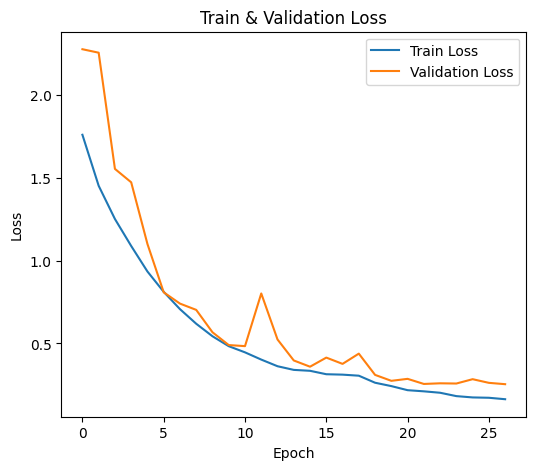

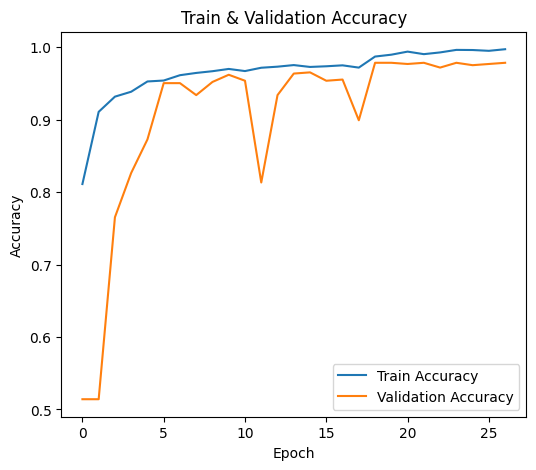

In [16]:
h = history

plt.figure(figsize=(6, 5)) 
plt.plot(h.history['loss'], label='Train Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Train & Validation Loss')  
plt.xlabel('Epoch') 
plt.ylabel('Loss')  
plt.legend()
plt.show()

plt.figure(figsize=(6, 5)) 
plt.plot(h.history['accuracy'], label='Train Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train & Validation Accuracy')  
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Confusion Matrix

Confusion Matrix:
[[752  16]
 [ 13 730]]


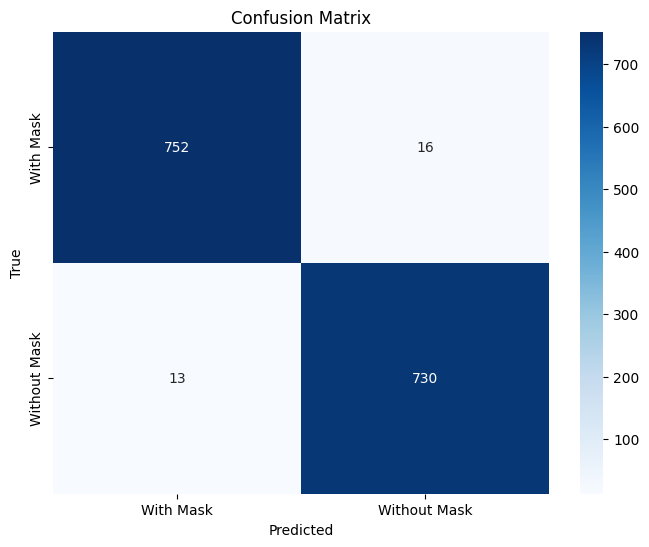

In [17]:
class_names = ['With Mask', 'Without Mask']

conf_matrix = confusion_matrix(Y_test, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # Creating Second Custom CNN Model

In [18]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape,
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(128, (3, 3), activation='relu',
                          depthwise_regularizer=regularizers.l2(0.001),
                          pointwise_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(256, (3, 3), activation='relu',
                          depthwise_regularizer=regularizers.l2(0.001),
                          pointwise_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

# Additional Block
model.add(SeparableConv2D(512, (3, 3), activation='relu',
                          depthwise_regularizer=regularizers.l2(0.001),
                          pointwise_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

# Flatten instead of GAP
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.35))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.35))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1,
    restore_best_weights=True, 
    min_delta=0.01
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3,
    min_lr=1e-6, 
    verbose=1
)

In [19]:
# Split data into training and validation sets
X_train_aug, X_val, Y_train_aug, Y_val = train_test_split(
   X_train_scaled, Y_train, test_size=0.1, random_state=42
)

# Data augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare augmented training data
train_generator = datagen.flow(X_train_aug, Y_train_aug, batch_size=32)

In [20]:
# Train the model with augmented data and validation set
history = model.fit(
    train_generator,
    validation_data=(X_val, Y_val),  # Use the separated validation set
    epochs=100,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 81s 445ms/step - accuracy: 0.6899 - loss: 2.0955 - val_accuracy: 0.5339 - val_loss: 2.1469 - learning_rate: 0.0010
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 415ms/step - accuracy: 0.8291 - loss: 1.6981 - val_accuracy: 0.5339 - val_loss: 2.5959 - learning_rate: 0.0010
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 74s 438ms/step - accuracy: 0.8804 - loss: 1.4665 - val_accuracy: 0.6165 - val_loss: 3.3953 - learning_rate: 0.0010
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 73s 426ms/step - accuracy: 0.9130 - loss: 1.2686 - val_accuracy: 0.9388 - val_loss: 1.0871 - learning_rate: 0.0010
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 72s 422ms/step - accuracy: 0.9254 - loss: 1.1118 - val_accuracy: 0.9124 - val_loss: 1.0106 - learning_rate: 0.0010
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 415ms/step - accuracy: 0.9244 - loss: 0.9828 - val_accuracy: 0.9736 - val_loss: 0.8183 - learning_rate: 0.0010
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 416ms/step - accura

In [21]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, Y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9904 - loss: 0.1407
Test Accuracy: 98.61%


In [28]:
model.save("face mask model.keras")  # Saves the trained model


In [22]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5)  # Convert probabilities to 0 or 1


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step


In [33]:
import os

# List only files with .h5 or .keras extension
model_files = [f for f in os.listdir() if f.endswith((".h5", ".keras"))]

print("Model files:", model_files)


Model files: ['face mask model.h5', 'face mask model.keras']


In [34]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("face mask model.keras")  # Replace with your actual model filename

def predict_mask(image_path):
    image_size = (128, 128)  

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Unable to load image. Check the file path.")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color format
    img = cv2.resize(img, image_size)  # Resize to match training size
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize pixel values

    # Predict using the model-
    prediction = model.predict(img)

    # Interpret the result
    if prediction[0][0] > 0.5:
        print("Prediction: No Mask ❌")
    else:
        print("Prediction: Mask ✅")

# Example usage
image_path = "C:\\Users\\hp\\Downloads\\mask.jpg"  # Replace with your test image path
predict_mask(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Prediction: Mask ✅


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import cv2

# Load Pretrained ResNet Model (Without Fully Connected Layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze ResNet Layers to Keep Pretrained Features
for layer in base_model.layers:
    layer.trainable = False

# Add Custom CNN Layers for Face Mask Classification
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification (Mask/No Mask)

# Define the Final Model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training Data Preparation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'E:\\biometrics face detection\\data',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'E:\\biometrics face detection\\data',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Save the Model Separately to Avoid Overwriting the CNN-Only Model
model.save("face mask model resnet.h5")

# Testing Function
def predict_mask(image_path):
    model = load_model("face mask model resnet.h5")

    # Load and preprocess the image
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Interpret the result
    if prediction > 0.5:
        print("No Mask Detected ❌")
    else:
        print("Mask Detected ✅")

# Example usage:
# predict_mask("test_image.jpg")  # Change "test_image.jpg" to your image file path


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 70s 1us/step
Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


E:\pythonnn\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 13/189 ━━━━━━━━━━━━━━━━━━━━ 1:51 633ms/step - accuracy: 0.5390 - loss: 1.0736

E:\pythonnn\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 171s 869ms/step - accuracy: 0.5695 - loss: 0.7658 - val_accuracy: 0.5371 - val_loss: 0.6959
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 124s 656ms/step - accuracy: 0.6381 - loss: 0.6329 - val_accuracy: 0.5735 - val_loss: 0.6680
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 119s 627ms/step - accuracy: 0.6548 - loss: 0.6104 - val_accuracy: 0.6046 - val_loss: 0.6474
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 119s 631ms/step - accuracy: 0.6784 - loss: 0.5948 - val_accuracy: 0.6801 - val_loss: 0.6155
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 119s 630ms/step - accuracy: 0.6913 - loss: 0.5772 - val_accuracy: 0.6768 - val_loss: 0.6301
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 121s 643ms/step - accuracy: 0.6908 - loss: 0.5748 - val_accuracy: 0.6291 - val_loss: 0.6338
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 124s 655ms/step - accuracy: 0.6849 - loss: 0.5756 - val_accuracy: 0.7278 - val_loss: 0.5810
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 130s 687ms/step - accuracy: 0.7126 - loss: 0.55

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


E:\pythonnn\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


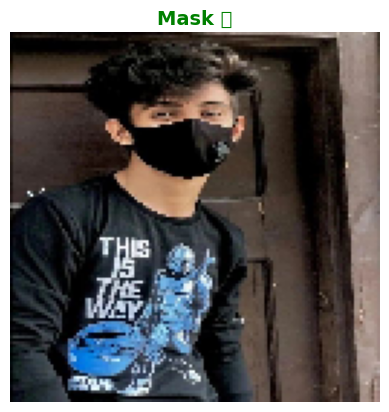

In [2]:
import matplotlib.pyplot as plt

def predict_mask(image_path):
    model = load_model("face mask model resnet.h5")  # Load the trained model

    # Load and preprocess the image
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Determine result
    result = "No Mask ❌" if prediction > 0.5 else "Mask ✅"

    # Display Image & Result
    plt.imshow(img)
    plt.axis("off")
    plt.title(result, fontsize=14, fontweight="bold", color="red" if prediction > 0.5 else "green")
    plt.show()

# Example usage
predict_mask("C:\\Users\\hp\\Downloads\\mask.jpg")  # Change with your image file path
